<a href="https://colab.research.google.com/github/machiwao/CCMACLRL_PROJECT_COM222/blob/main/project_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Shopee Computer Product Reviews

In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import requests

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from scipy.sparse import hstack

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

In [150]:
df = pd.read_csv("hf://datasets/magixxixx/shopee-product-reviews-on-computer-category/combined-dataset-shuffled-cased-40K.csv")

In [151]:
df.head()

,text,sentiment
0,mali yung dineliver 2l order ko naging 1l bulok!,0
1,xl order ko dumating large.nkalagay sa sticker...,0
2,"sobrang bilis ma lowbat, hindi masyado nakaka ...",0
3,first time ko umorder dito. di naman gumagana ...,0
4,"not well packed, wala itong box. hindi sya ma ...",0


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [153]:
df.isnull().sum()

,0
text,0
sentiment,0


In [154]:
df.duplicated().sum()

1

In [155]:
df['sentiment'].value_counts()

,count
sentiment,
0,20000
1,20000


## Data Preprocessing

In [156]:
df.drop_duplicates(inplace = True)

In [157]:
def get_stopwords(url):
    response = requests.get(url)
    response.encoding = 'utf-8' # Ensure proper encoding for Filipino text
    stopwords_list = response.text.splitlines()
    return stopwords_list

# Load Filipino stop words
combined_stopwords = set(stopwords.words('english')) | set(get_stopwords("https://raw.githubusercontent.com/stopwords-iso/stopwords-tl/master/raw/genediazjr-tagalog.txt"))

In [158]:
bad_words = ["amputa","animal ka","bilat","binibrocha","bobo","bogo","boto",
             "brocha","burat","bwesit","bwisit","demonyo ka","engot","etits",
             "gaga","gagi","gago","habal","hayop ka","hayup","hinampak",
             "hinayupak","hindot","hindutan","hudas","iniyot","inutel","inutil",
             "iyot","kagaguhan","kagang","kantot","kantotan","kantut","kantutan",
             "kaululan","kayat","kiki","kikinginamo","kingina","kupal","leche",
             "leching","lechugas","lintik","nakakaburat","nimal","ogag","olok",
             "pakingshet","pakshet","pakyu","pesteng yawa","poke","poki",
             "pokpok","poyet","pu'keng","pucha","puchanggala","puchangina",
             "puke","puki","pukinangina","puking","punyeta","puta","putang",
             "putang ina","putangina","putanginamo","putaragis","putragis",
             "puyet","ratbu","shunga","sira ulo","siraulo","suso","susu","tae",
             "taena","tamod","tanga","tangina","taragis","tarantado","tete",
             "teti","timang","tinil","tite","titi","tungaw","ulol","ulul",
             "ungas", "yawa"]

bad_words_pattern = re.compile(r'\b(' + '|'.join([re.escape(word) for word in bad_words]) + r')\b', re.IGNORECASE)

In [159]:
def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  text = bad_words_pattern.sub('[PROFANITY]', text)
  # remove_digits_urls_special_chars
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove non-alphabetic characters
  text = re.sub(r'\b(\w+)\1+\b', r'\1', text)  # Reduce repeated words to root word
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\s+$', '', text)
  text = re.sub(r'\d+', '', text)


  text = ' '.join([word for word in text.split() if word not in combined_stopwords])

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [160]:
def reduce_repeating_letters(word):
    if not word:
        return ""

    reduced_word = [word[0]]  # Start with the first character
    for char in word[1:]:
        if char != reduced_word[-1]:  # Compare with the last added character
            reduced_word.append(char)

    return ''.join(reduced_word)

In [161]:
df['text'] = df['text'].apply(reduce_repeating_letters)
df['text'] = df['text'].apply(preprocess_text)

## Training the Model

In [162]:
X = df['text']
y = df['sentiment']

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [164]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

(31999,) (31999,)
(8000,) (31999,)


In [165]:
print(y_train.value_counts())

sentiment
0    16032
1    15967
Name: count, dtype: int64


In [166]:
print(y_test.value_counts())

sentiment
1    4032
0    3968
Name: count, dtype: int64


In [167]:
combined_stopwords_list = list(combined_stopwords)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5, stop_words=combined_stopwords_list)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

In [169]:
print(X_train_transformed.shape)
print(X_test_transformed.shape)

(31999, 19431)
(8000, 19431)


## Training Baseline Models

In [ ]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

In [ ]:
for model_name, model in models.items():
    accuracy, report = train_and_evaluate(model, X_train_transformed, y_train, X_test_transformed, y_test)
    print(f"{model_name}:\nAccuracy: {accuracy}\nReport:\n{report}\n")

Naive Bayes:
Accuracy: 0.96125
Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3968
           1       0.98      0.95      0.96      4032

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000


Logistic Regression:
Accuracy: 0.965375
Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3968
           1       0.97      0.96      0.97      4032

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


SVM:
Accuracy: 0.96925
Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3968
           1       0.98      0.96      0.97      4032

    accuracy                           0.97      8000
   macro

In [ ]:
from sklearn.svm import SVC

model = SVC()

### Hyperparameter Tuning and Cross Validation

In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale','auto']
}

In [ ]:
grid = GridSearchCV(model, param_grid, refit=True, cv=5, n_jobs= -1, return_train_score=True, verbose=0)

# Train with grid search
grid.fit(X_train_transformed, y_train)

# Access cv_results_ to extract scores
cv_results = grid.cv_results_

# Iterate over all combinations of parameters
for i in range(len(cv_results['params'])):
    print(f"Iteration {i+1}:")
    print(f"Parameters: {cv_results['params'][i]}")

    # Train accuracy for this iteration
    train_acc = cv_results['mean_train_score'][i]
    print(f"Train Accuracy: {train_acc:.4f}")

    # Test accuracy for this iteration (mean cross-validated test score)
    test_acc = cv_results['mean_test_score'][i]
    print(f"Test Accuracy: {test_acc:.4f}")
    print('-' * 50)

Iteration 1:
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 2:
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Train Accuracy: 0.9579
Test Accuracy: 0.9471
--------------------------------------------------
Iteration 3:
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 4:
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Train Accuracy: 0.9371
Test Accuracy: 0.9342
--------------------------------------------------
Iteration 5:
Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 6:
Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Train Accuracy: 0.5814
Test Accuracy: 0.5798
--------------------------------------------------
Iteration 7:
Pa

In [ ]:
# Best parameters
print("Best Parameters: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

Best Parameters:  {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}
Best Estimator:  SVC(C=5, gamma=0.1)


In [181]:
# Chosen Model
model = SVC(C = 5, gamma = 0.1, kernel = 'rbf')
model.fit(X_train_transformed, y_train)

SVC(C=5, gamma=0.1)

In [ ]:
# Cross Validation
X_transformed = vectorizer.transform(X)
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(cv_scores)
print(cv_scores.mean())
print(cv_scores.std())

[0.97025    0.9685     0.96775    0.972125   0.96812102]
0.9693492030253783
0.0016311667997165895


## Model Testing

In [182]:
y_pred = model.predict(X_test_transformed)
final_test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy of Best Model: {final_test_acc:.4f}")


Final Test Accuracy of Best Model: 0.9714


In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3968
           1       0.97      0.97      0.97      4032

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



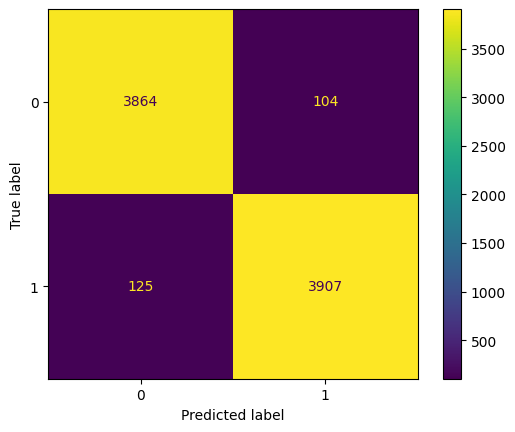

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [191]:
'''input_texts = ['This shit is so damn good product',
               'Hindi niyo ako maloloko! Original to noh? Ang ganda!',
               'Tangina good shit!', 'Tagal niya dumating pero ang solid hahaha',
               'Ito na yon? Hindi man lang tumagal.', 'Anggggg gandaaaaaa.',
               'Ayos gumana! natest ko na din sa OS no issues so far, will update if there will be, sana tumagal. dito na kayo bumili maayos kausap si seller tska responsive. order ako ulet SSDs naman.',
               'Nagorder ak intel heatsink fan daw. pero hindi intel dumating. scam.',
               'Sira yung isang pin buti nalang may available ako na pin sa luma ko ayun nalang ginamit kong pin',
               'Good legit seller. Maayos kausap at good quality. Sobrang ganda at ma ayos ang pag ka balot sa item. Uulit ulit ako nag order dito sa shop nya .',
               'd ako binigo ni it world , solid as usual , naka discount pa dahil sa vouchers ! good na good :D',
               'normal lng ba to? patukin Muna pra gumana?',
               'sakto lng..dko sure kung nbagsak kasi may dent s kanto ng unit..ewan kung si seller o si jnt',
               'Now lang nagreview kasi gusto ko muna sya itry..so far sa ilang days na gamit ko sya di nman ako binigo..sana mas magtagal pa..legit may kasama ding extra fuse.',
               "good except the BIOS. It's not graphical and very basic AMI BIOS.",
               "Dalawang USB port lang gumagana, mouse keyboard lang nasaksak ko, Yung apat na USB port di gumagana, sad tyaka Yung power Buti nagamit pa, pero Yung pang restart at LED, ayaw",
               "Works just fine at first. Pero bigla nalng sumabog. Yikes"
               "Dalawa binili ko. Yung isa pag open na pag open palang yupi. Awit eh..",
               "gumagana naman. may dent yung kanto at naka angat yung likod.",
               "Kung sino man nagbabasa neto, bilhin mo nato. LF kasama sa scam"
               ]'''
input_texts = ["kvpal ka ba boss?! 3200mhz inorder ko tapos 2133mhz ibibigay mo?",
                     "A bit disappointed na unsealed na yung item, pero Ok na rin dahil gumana ana ang PC",
                     "Tang*na mo seller na budol ako di maayus puny*ta ka",
                     "pede na po hehe", "Sayang excited pa naman ako Gamitin kaso may damage pala.",
                     "Delivered safe and working, but does not look durable. Plug cable too thin",
                     "Putik damage ayaw na palitan. Kahit may unboxing video damage item kitang kita.",
                     "All working. All power **Pingkot yung box hindi iningatan. All box matters",
                     "Sablay mag pisowifi ka nalang kesa dito",
                     "akala ko sira hindi gumana ang coinslot sinubukan ko lang ni reflash success gumana ng maayos maganda ang performance sana tumagal"]

In [192]:
for text in input_texts:
  input_text = pd.Series(text)
  input_text = input_text.apply(reduce_repeating_letters)
  input_text = input_text.apply(preprocess_text)
  input_text_transform = vectorizer.transform(input_text)
  prediction = model.predict(input_text_transform)
  if prediction == 0:
    print(f"Review: {text} -> Sentiment: Bad")
  else:
    print(f"Review: {text} -> Sentiment: Good")

Review: kvpal ka ba boss?! 3200mhz inorder ko tapos 2133mhz ibibigay mo? -> Sentiment: Bad
Review: A bit disappointed na unsealed na yung item, pero Ok na rin dahil gumana ana ang PC -> Sentiment: Bad
Review: Tang*na mo seller na budol ako di maayus puny*ta ka -> Sentiment: Bad
Review: pede na po hehe -> Sentiment: Bad
Review: Sayang excited pa naman ako Gamitin kaso may damage pala. -> Sentiment: Bad
Review: Delivered safe and working, but does not look durable. Plug cable too thin -> Sentiment: Good
Review: Putik damage ayaw na palitan. Kahit may unboxing video damage item kitang kita. -> Sentiment: Bad
Review: All working. All power **Pingkot yung box hindi iningatan. All box matters -> Sentiment: Good
Review: Sablay mag pisowifi ka nalang kesa dito -> Sentiment: Bad
Review: akala ko sira hindi gumana ang coinslot sinubukan ko lang ni reflash success gumana ng maayos maganda ang performance sana tumagal -> Sentiment: Bad
